<a href="https://colab.research.google.com/github/raghavadevarajeurs/DeepLearning/blob/main/Assignment3/Assignment3_PartB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building 3 layer Neural Network using Pytorch tensor with high level primitives

In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import plotly.graph_objects as pltgo

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

#Generating sample data for 3d input and 2d output

In [17]:
def get_true_labels(X, weights_true, bias_true):
  return (X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

In [18]:
n_samples = 150
input_dim = 3
output_dim = 2

torch.manual_seed(1)
max = 1
min = -1
X = (max - min) * torch.rand((n_samples, input_dim)) + min
print('Sample X: ' + str(X[:2]))

weights_true = torch.tensor([[5., 1., 3.], [2., 1., 1.]])
bias_true = torch.tensor([[1.], [1.]])

y_true = get_true_labels(X, weights_true, bias_true)
print('Sample Y: ' + str(y_true[:2]))

Sample X: tensor([[ 0.5153, -0.4414, -0.1939],
        [ 0.4694, -0.9414,  0.5997]])
Sample Y: tensor([[4.1884, 2.1587],
        [7.2714, 3.2836]])


#Drawing the 3 Dimensional data plot

In [19]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=1234).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

In [20]:
def plot_go_3d(x, y, y_pred=None):
  
  fig = pltgo.Figure()
  fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y.reshape([-1]),
                    name='y_true', mode='markers', marker=dict( size=10, color='dodgerblue', colorscale='Viridis', opacity=0.5)))
  if y_pred is not None:
    fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y_pred.reshape([-1]),
                   name='y_pred', mode='markers', marker=dict( size=10, color='goldenrod', colorscale='Viridis', opacity=0.5)))
  fig.update_layout(margin=dict(r=20, b=10, l=10, t=10))
  fig.show()

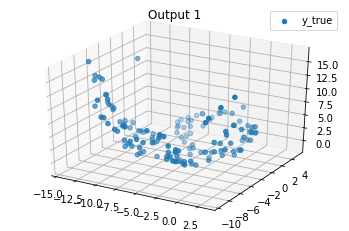

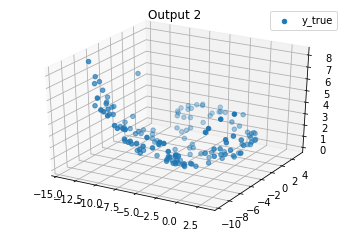

In [21]:
plot_3d('Output 1', X, y_true[:,0])
plot_3d('Output 2', X, y_true[:,1])

In [22]:
X_reduced = TSNE(n_components=2).fit_transform(X)
y_true_reduced = TSNE(n_components=1).fit_transform(y_true)
plot_go_3d(X_reduced,y_true_reduced)

#Build Nueral Network

In [23]:
class NeuralNet(nn.Module):
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    super(NeuralNet, self).__init__()

    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    layers_nodes = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
    layers = []
    for i in range(len(layers_nodes[:-1])):
      # Don't add activation function to last layer because this is a regression problem
      if i == len(layers_nodes[:-1]) - 1:
        layers.append(nn.Linear(layers_nodes[i], layers_nodes[i + 1]))
      else:
        layers.append(nn.Linear(layers_nodes[i], layers_nodes[i + 1]))
        if activation == 'relu':
          layers.append(nn.ReLU())

    self.layers = nn.ModuleList(layers)

  def forward(self, x):
    curr_out = X
    for layer in self.layers:
      curr_out = layer(curr_out)
    return curr_out
  
  def fit(self, X, y_true, lr, epochs):
    loss_fn  = nn.MSELoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    for epoch in range(epochs):
      optimizer.zero_grad()
      y_pred = self.forward(X)
      error = loss_fn(y_pred, y_true)
      print(error)
      error.backward()
      optimizer.step()

#HyperParameters

In [24]:
epochs = 150
lr = 0.01

n_inputs = X.shape[1]
n_outputs = y_true.shape[1]

#Training NN withuot any activation function

In [25]:
model = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation=None)
print('Neural Network Architecture:')
print(model.layers)
print()

for name, param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

model.fit(X, y_true, lr, epochs)

y_pred = model.forward(X).detach().numpy()
err = mean_squared_error(y_true, y_pred)
print('Final Mean Squared Error: {}'.format(err))

Neural Network Architecture:
ModuleList(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=3, bias=True)
  (2): Linear(in_features=3, out_features=2, bias=True)
)

Layer: layers.0.weight | Size: torch.Size([4, 3]) | Values : tensor([[ 0.1934,  0.3160,  0.5723],
        [-0.0603,  0.5554,  0.3709]], grad_fn=<SliceBackward>) 

Layer: layers.0.bias | Size: torch.Size([4]) | Values : tensor([0.4212, 0.1730], grad_fn=<SliceBackward>) 

Layer: layers.1.weight | Size: torch.Size([3, 4]) | Values : tensor([[-0.3560, -0.1093,  0.0049, -0.2889],
        [-0.1278, -0.2156,  0.4765,  0.4248]], grad_fn=<SliceBackward>) 

Layer: layers.1.bias | Size: torch.Size([3]) | Values : tensor([ 0.1843, -0.3667], grad_fn=<SliceBackward>) 

Layer: layers.2.weight | Size: torch.Size([2, 3]) | Values : tensor([[-0.3133,  0.0918,  0.1912],
        [ 0.4982, -0.3029, -0.4542]], grad_fn=<SliceBackward>) 

Layer: layers.2.bias | Size: torch.Size([2]) | Values : tensor(

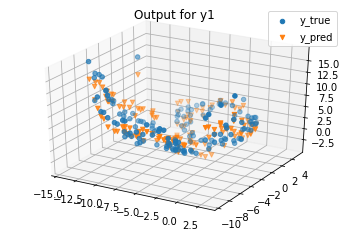

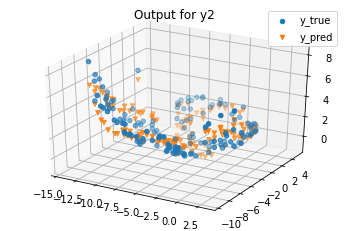

In [26]:
plot_3d('Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2', X, y_true[:,1], y_pred[:,1])

In [27]:
X_plot = TSNE(n_components=2).fit_transform(X)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)

#Training NN with ReLU activation function

In [28]:
model = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation='relu')
print('Neural Network Architecture:')
print(model.layers)
print()

for name, param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

model.fit(X, y_true, lr, epochs)

y_pred = model.forward(X).detach().numpy()
err = mean_squared_error(y_true, y_pred)
print('Final Mean Squared Error: {}'.format(err))

Neural Network Architecture:
ModuleList(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=2, bias=True)
)

Layer: layers.0.weight | Size: torch.Size([4, 3]) | Values : tensor([[ 0.2806,  0.2078, -0.2044],
        [ 0.3473, -0.5040,  0.0803]], grad_fn=<SliceBackward>) 

Layer: layers.0.bias | Size: torch.Size([4]) | Values : tensor([-0.4798, -0.5192], grad_fn=<SliceBackward>) 

Layer: layers.2.weight | Size: torch.Size([3, 4]) | Values : tensor([[-0.2961, -0.2114, -0.4427,  0.3073],
        [-0.1145, -0.3155,  0.1302, -0.3739]], grad_fn=<SliceBackward>) 

Layer: layers.2.bias | Size: torch.Size([3]) | Values : tensor([-0.3297, -0.2707], grad_fn=<SliceBackward>) 

Layer: layers.4.weight | Size: torch.Size([2, 3]) | Values : tensor([[-0.5709, -0.4280,  0.2637],
        [-0.1891, -0.2297, -0.4776]], grad_fn=<SliceBackward>) 

Layer: layers.4.bias | Size: torc

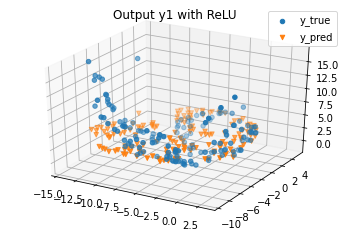

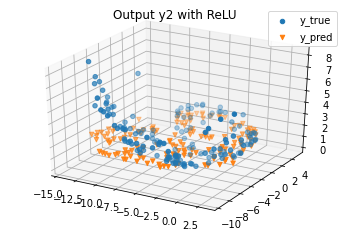

In [29]:
plot_3d('Output y1 with ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output y2 with ReLU', X, y_true[:,1], y_pred[:,1])

In [30]:
X_plot = TSNE(n_components=2).fit_transform(X)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)